In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

In [23]:
# データをデータフレームとして読み込む
items = pd.read_csv('../data/items.csv')
item_categories = pd.read_csv('../data/item_categories.csv')
shops = pd.read_csv('../data/shops.csv')
sales_train = pd.read_csv('../data/sales_train.csv')
test = pd.read_csv('../data/test.csv')

In [24]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


item_category_nameを文字列 " - "で前後に分割できそう。

In [25]:
item_categories["big_category_name"] = item_categories["item_category_name"].map(lambda x: x.split(' - ')[0])
item_categories["big_category_name"].value_counts()

Книги                                13
Подарки                              12
Игровые консоли                       8
Игры                                  8
Аксессуары                            7
Программы                             6
Музыка                                6
Кино                                  5
Игры PC                               4
Карты оплаты                          4
Служебные                             2
Чистые носители (штучные)             1
Билеты (Цифра)                        1
Игры MAC                              1
Чистые носители (шпиль)               1
Игры Android                          1
Доставка товара                       1
Элементы питания                      1
PC                                    1
Карты оплаты (Кино, Музыка, Игры)     1
Name: big_category_name, dtype: int64

In [26]:
# Чистые носители (штучные),Чистые носители (шпиль)は一緒？
item_categories.loc[
    item_categories['big_category_name']=='Чистые носители (штучные)',
    'big_categry'
] = 'Чистые носители (шпиль)'
# 再度集約具合を確認
item_categories['big_category_name'].value_counts()

Книги                                13
Подарки                              12
Игровые консоли                       8
Игры                                  8
Аксессуары                            7
Программы                             6
Музыка                                6
Кино                                  5
Игры PC                               4
Карты оплаты                          4
Служебные                             2
Чистые носители (штучные)             1
Билеты (Цифра)                        1
Игры MAC                              1
Чистые носители (шпиль)               1
Игры Android                          1
Доставка товара                       1
Элементы питания                      1
PC                                    1
Карты оплаты (Кино, Музыка, Игры)     1
Name: big_category_name, dtype: int64

In [27]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


「!Якутск Орджоникидзе」は「ヤクーツク・オルゾニキゼ」らしいです。
ググってみると、ヤクーツクは都市名のようでした。
つまり、" "で文字列分割すると、都市名を抽出できることになるので、以下、shop_nameからcity_name(都市名)を抽出します。

In [28]:
shops['city_name'] = shops['shop_name'].map(lambda x: x.split(' ')[0])
# 集約具合を確認
shops['city_name'].value_counts()

Москва              13
Тюмень               3
РостовНаДону         3
Воронеж              3
!Якутск              2
Уфа                  2
Казань               2
Красноярск           2
Новосибирск          2
Жуковский            2
Самара               2
СПб                  2
Якутск               2
Н.Новгород           2
Сергиев              1
Ярославль            1
Химки                1
Цифровой             1
Томск                1
Калуга               1
Интернет-магазин     1
Мытищи               1
Омск                 1
Выездная             1
Курск                1
Вологда              1
Сургут               1
Коломна              1
Балашиха             1
Чехов                1
Волжский             1
Адыгея               1
Name: city_name, dtype: int64

In [29]:
shops.loc[shops['city_name']=='!Якутск','city_name'] = 'Якутск'
# 再度集約具合を確認
shops['city_name'].value_counts()


Москва              13
Якутск               4
Воронеж              3
Тюмень               3
РостовНаДону         3
Уфа                  2
Казань               2
Красноярск           2
Новосибирск          2
Жуковский            2
Самара               2
СПб                  2
Н.Новгород           2
Сергиев              1
Ярославль            1
Химки                1
Цифровой             1
Томск                1
Калуга               1
Интернет-магазин     1
Мытищи               1
Омск                 1
Выездная             1
Адыгея               1
Курск                1
Сургут               1
Коломна              1
Балашиха             1
Чехов                1
Волжский             1
Вологда              1
Name: city_name, dtype: int64

In [30]:
# 売上金額カラムが存在しないので、新たにdate_sales(売上金額)を作成しておきます。

# 日次売り上げ額
sales_train['date_sales'] = sales_train['item_cnt_day'] * sales_train['item_price']

## 予測に必要な粒度にデータを変換

このタスクのゴールは、テストデータセットに含まれる店舗ID * 商品IDを対象に、2015/11の商品売上数を予測することです。<br>
上記のためには築地で売上データを集約し、かつ、テストデータセットに含まれる店舗ID * 商品IDのみの学習データを準備する必要があります。

In [31]:
# 月次shop_id*item_id別売上点数
mon_shop_item_cnt = sales_train[
    ['date_block_num','shop_id','item_id','item_cnt_day']
].groupby(
    ['date_block_num','shop_id','item_id'],
    as_index=False
).sum().rename(columns={'item_cnt_day':'mon_shop_item_cnt'})
# 月次shop_id*item_id別売上金額
mon_shop_item_sales = sales_train[
    ['date_block_num','shop_id','item_id','date_sales']
].groupby(
    ['date_block_num','shop_id','item_id'],
    as_index=False
).sum().rename(columns={'date_sales':'mon_shop_item_sales'})

## テストデータの組み合わせに学習データをトリム

テストデータセットに含まれる店舗ID * 商品ID、かつ、月のシーケンス(date_block_num)が0 ~ 34の組み合わせを生成します。

In [32]:
# 学習データセットをフルに拡張
# 34月 * shop_id * item_id

train_full_comb = pd.DataFrame()
for i in range(35):
    mid = test[["shop_id", "item_id"]]
    mid["date_block_num"] = i
    train_full_comb = pd.concat([train_full_comb, mid], axis=0)

In [33]:
# これに月次集計データ及びマスタを結合させます

train = pd.merge(
    train_full_comb,
    mon_shop_item_cnt,
    on=["date_block_num", "shop_id", "item_id"],
    how="left"
)

# 月次売上金額
train = pd.merge(
    train,
    mon_shop_item_sales,
    on=["date_block_num", "shop_id", "item_id"],
    how="left"
)

# 学習データにマスタをマージ
# item_idのjoin
train = pd.merge(
    train,
    items[['item_id', "item_category_id"]],
    on='item_id',
    how='left'
)

# item_category_idのjoin
train = pd.merge(
    train,
    item_categories[["item_category_id", "big_category_name"]],
    on="item_category_id",
    how="left"
)

# shop_idのjoin
train = pd.merge(
    train,
    shops[["shop_id", "city_name"]],
    on="shop_id",
    how='left'
)

## データ可視化

築地の商品売上数のトレンドを可視化します。<br>
まずは、月次の商品売上数の合計から見てみましょう

Text(0.5, 1.0, 'Montly item counts')

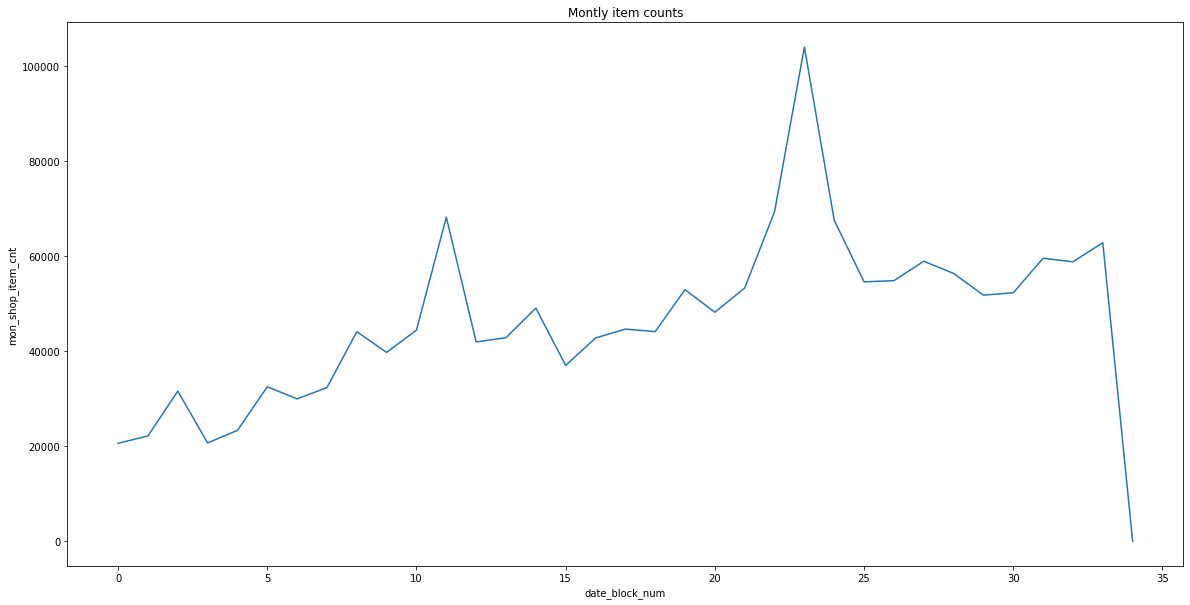

In [34]:
plt_df = train.groupby(
    ['date_block_num'],
    as_index=False
).sum()
plt.figure(figsize=(20, 10))
sns.lineplot(x='date_block_num',y='mon_shop_item_cnt',data=plt_df)
plt.title('Montly item counts')

Text(0.5, 1.0, 'Montly item counts by big category')

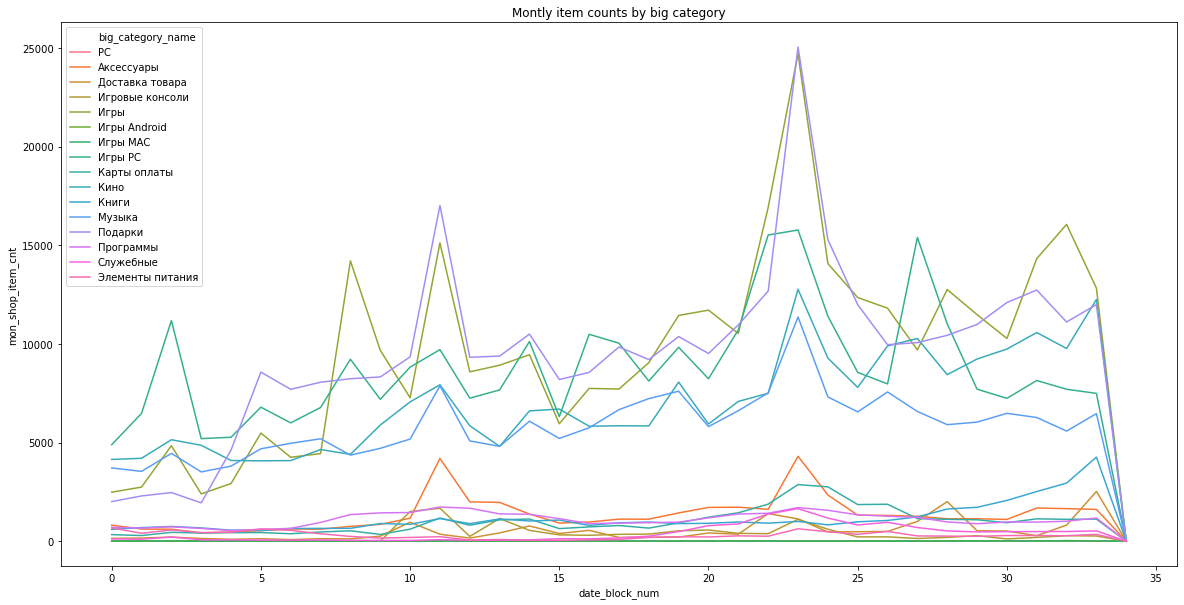

In [36]:
plt_df = train.groupby(
    ['date_block_num','big_category_name'],
    as_index=False
).sum()
plt.figure(figsize=(20, 10))
sns.lineplot(x='date_block_num',y='mon_shop_item_cnt',data=plt_df,hue='big_category_name')
plt.title('Montly item counts by big category')

Text(0.5, 1.0, 'Montly item counts by city_name')

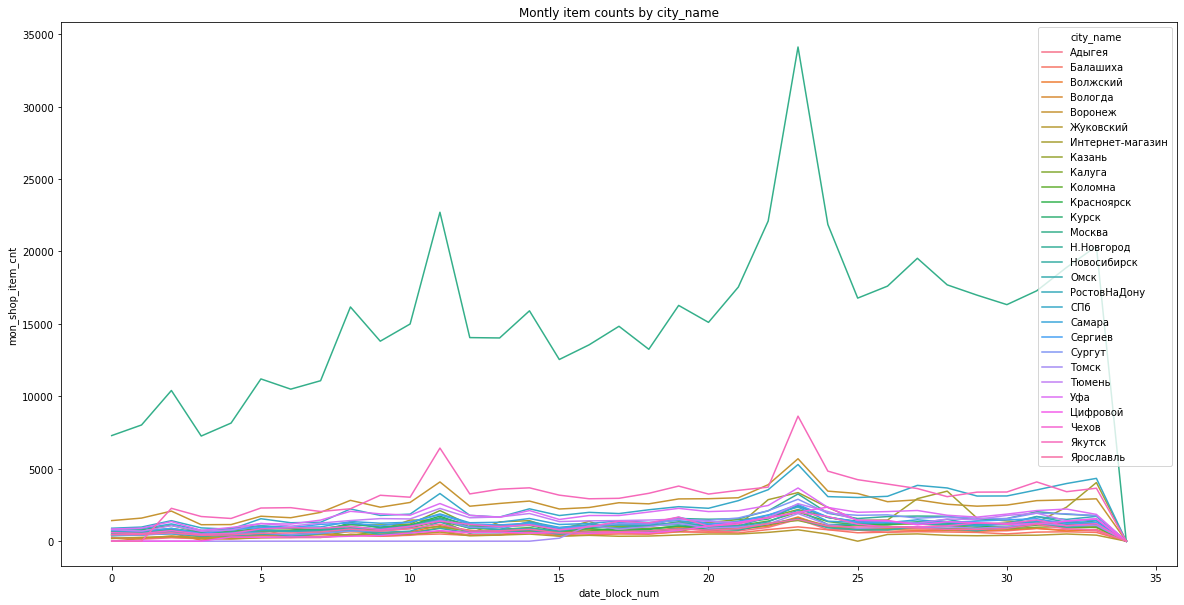

In [37]:
plt_df = train.groupby(
    ['date_block_num','city_name'],
    as_index=False
).sum()
plt.figure(figsize=(20, 10))
sns.lineplot(x='date_block_num',y='mon_shop_item_cnt',data=plt_df,hue='city_name')
plt.title('Montly item counts by city_name')

## ラグ特徴量の作成

#### ラグ特徴量とは何か？
ラグ特徴量のラグはタイムラグとかのラグと同じです。今の時間の特徴だけに注目せずに過去の特徴を用いて現在のデータの特徴量を増やす方法です。<br>
<br>
過去と明言しましたが、未来のデータを使うケースもたまにあります。<br>
<br>
Basic Feature Engineering With Time Series Data in PythonBasic Feature Engineering With Time Series Data in Python - Machine Learning Mastery<br>
Time Series data must be re-framed as a supervised learning d<br>
machinelearningmastery.com<br>
<br>

https://note.com/hirayuki/n/n344726ab59ee

In [40]:
train["mon_shop_item_cnt"] = train["mon_shop_item_cnt"].clip(0,20)

In [42]:
# ラグ生成対象のカラム
lag_col_list = ['mon_shop_item_cnt', 'mon_shop_item_sales']
# ラグリスト(1ヶ月前, 3ヶ月前, 6ヶ月前, 9ヶ月前, 12ヶ月前)
lag_num_list = [1,3,6,9,12]

# shop_id * item_id * date_block_numでソート
train = train.sort_values(
    ["shop_id", "item_id", "date_block_num"],
    ascending=[True, True, True],
).reset_index(drop=True)

# ラグ特徴量の作成
for lag_col in lag_col_list:
    for lag in lag_num_list:
        set_col_name = lag_col + '_' + str(lag)
        df_lag = train[['shop_id', 'item_id', 'date_block_num', lag_col]].sort_values(
            ['shop_id', 'item_id', 'date_block_num'],
            ascending=[True, True, True]
        ).reset_index(drop=True).shift(lag).rename(columns={lag_col: set_col_name})
        trian = pd.concat([train, df_lag[set_col_name]], axis=1)

In [43]:
train = train.fillna(0)

## 予測モデルの構築
まず学習データセットとテストデータセットを分割します。
ラグ特徴量で最大12ヶ月前を使用しているため、学習データセットにはdate_block_numが12~33のデータ、テストデータセットにはdate_block_numが34のデータを割り当てます。

In [44]:
# ラグで最大12ヶ月前の売上数を使用するため
train_ = train[(train['date_block_num']<=33) & (train['date_block_num']>=12)].reset_index(drop=True)
test_ = train[train['date_block_num']==34].reset_index(drop=True)

# モデルに入力する特徴量とターゲット変数に分割
train_y = train_['mon_shop_item_cnt']
train_X = train_.drop(columns=['date_block_num','mon_shop_item_cnt', 'mon_shop_item_sales'])
test_X = test_.drop(columns=['date_block_num','mon_shop_item_cnt', 'mon_shop_item_sales'])


In [45]:
# ラベルエンコーディング
from sklearn.preprocessing import LabelEncoder
obj_col_list = ['big_category_name','city_name']
for obj_col in obj_col_list:
    le = LabelEncoder()
    train_X[obj_col] = pd.DataFrame({obj_col:le.fit_transform(train_X[obj_col])})
    test_X[obj_col] = pd.DataFrame({obj_col:le.fit_transform(test_X[obj_col])})

In [46]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(train_X,train_y)

RandomForestRegressor()

Text(0.5, 1.0, 'Importance of features')

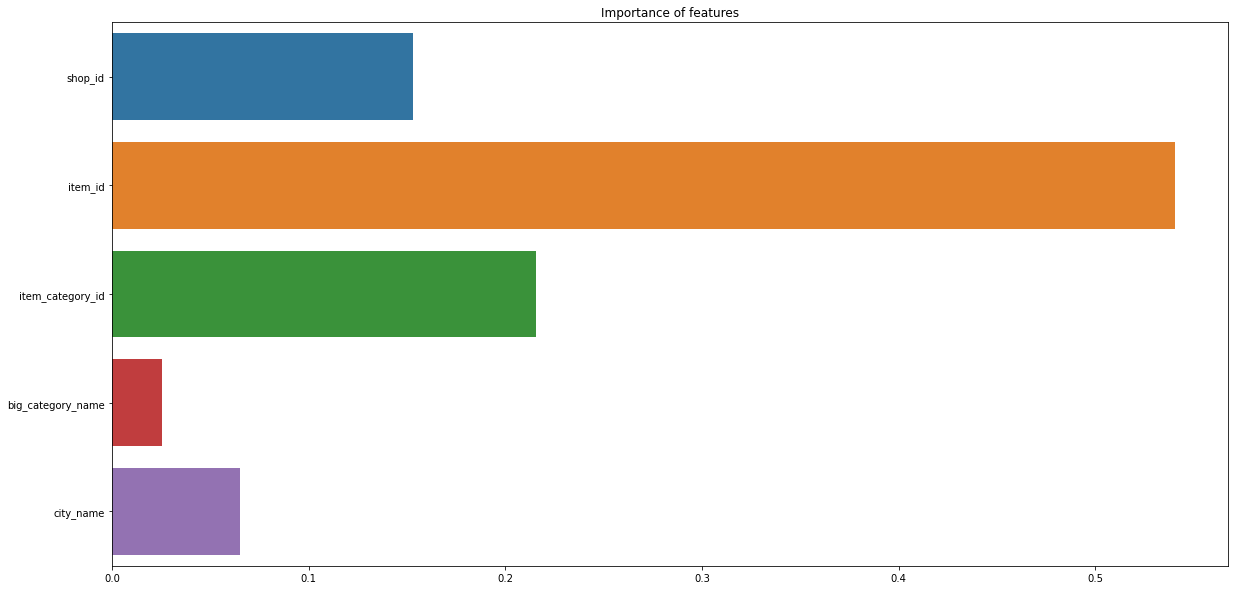

In [47]:
plt.figure(figsize=(20, 10))
sns.barplot(
    x=rfr.feature_importances_,
    y=train_X.columns.values
)
plt.title('Importance of features')

In [48]:
np.sqrt(
    np.mean(
        np.square(
            np.array(
                np.array(train_y) - rfr.predict(train_X)
            )
        )
    )
)

0.8543669922548518

In [50]:
test_y = rfr.predict(test_X)
test_X['item_cnt_month'] = test_y
submission = pd.merge(
    test,
    test_X[['shop_id','item_id','item_cnt_month']],
    on=['shop_id','item_id'],
    how='left'
)
# 提出ファイル作成
submission[['ID','item_cnt_month']].to_csv('../data/submission_files/submission.csv', index=False)


ValueError: Number of features of the model must match the input. Model n_features is 5 and input n_features is 6 